# Preprocessing functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

def scaling(Features,s_type):
    not_one_hot_col = []
    for i in Features:
        if Features[i].dtypes != 'bool':
            not_one_hot_col.append(i)
    scaler = StandardScaler()
    if s_type =='standard':
        scaler = StandardScaler()
    elif s_type =='minmax':
        scaler = MinMaxScaler()
    Features[not_one_hot_col] = scaler.fit_transform(Features[not_one_hot_col])

def preprocessing(dataframe,target,scaling_type='minmax',selection_criteria='correlation',feature_count=20):
    # drop target column null datapoints
    dataframe.dropna(subset=[target], inplace=True)

    # fill in missing null values
    for i in dataframe:
        if dataframe[i].dtypes=='object':
            dataframe.fillna({i:dataframe[i].mode()[0]}, inplace=True)
        else:
            dataframe.fillna({i:dataframe[i].mean()}, inplace=True)
    
    # drop duplicates
    dataframe.drop_duplicates(inplace=True)
    
    # convert to categorical for one hot encoding
    categorical_columns = []
    for i in dataframe:
        if dataframe[i].dtypes == 'object':
            categorical_columns.append(i)

    for i in categorical_columns:
        dataframe[i] = dataframe[i].astype('category')
    
    Features = dataframe.drop(target,axis=1)
    Labels = dataframe[target]

    # one hot and label encoding
    Features = pd.get_dummies(Features)
    encoder = LabelEncoder()
    Labels = encoder.fit_transform(Labels)

    # scaling feature values
    scaling(Features,scaling_type)
    
    # feature selection
    if selection_criteria=='correlation':
        Labels_df = pd.DataFrame(Labels,columns=[target])
        Labels_series = Labels_df[target]
        correlations = Features.corrwith(Labels_series)
        Features = Features[abs(correlations).sort_values(ascending=False).head(feature_count).index]
    elif selection_criteria=='information gain':
        mi_scores = mutual_info_classif(Features, Labels, discrete_features='auto')
        mi_scores_df = pd.DataFrame({'Feature': Features.columns, 'Information Gain': mi_scores})
        top_features = mi_scores_df.nlargest(feature_count, 'Information Gain')
        Features = Features[top_features['Feature']]

    Features = Features.to_numpy().astype(float)
    return Features,Labels

# Dataset selection

In [2]:
# # For first dataset
# dataframe = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
# dataframe = dataframe.drop("customerID",axis=1)
# dataframe['TotalCharges'] = pd.to_numeric(dataframe['TotalCharges'], errors='coerce')
# Features,Labels = preprocessing(dataframe,'Churn',feature_count=30)
# X, X_test, y, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=96)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=16)


# # For second dataset
# dataframe = pd.read_csv("adult.data", header=None)
# dataf = pd.read_csv("adult.test",skiprows=1,header=None)
# dataf[14] = dataf[14].replace(' <=50K.',' <=50K')
# dataf[14] = dataf[14].replace(' >50K.',' >50K')
# index = dataframe.shape[0]
# dataframe = pd.concat([dataframe,dataf], ignore_index=True)
# Features,Labels = preprocessing(dataframe,14,feature_count=30)
# X_test = Features[index:]
# y_test = Labels[index:]
# X = Features[:index]
# y = Labels[:index]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=16)


# # For third dataset
# dataframe = pd.read_csv("creditcard.csv")
# dataframe = pd.concat([dataframe[dataframe['Class']==1], dataframe[dataframe['Class']==0].sample(n=20000, random_state=16)], ignore_index=True)
# Features,Labels = preprocessing(dataframe,'Class')
# X, X_test, y, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=96)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=16)

# For Online
dataframe = pd.read_csv("A1.csv")
Features,Labels = preprocessing(dataframe,'y',selection_criteria='none')
X, X_test, y, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=96)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=16)


# Logistic Regression and Ensemble Learning Class

In [3]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,precision_score,f1_score,roc_auc_score,average_precision_score

class LogisticRegression:
    def __init__(self, learning_rate=0.001, epochs=1000, regularization='none', lambda_ = 0.01):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.regularization = regularization
        self.lamda_ = lambda_

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        X = np.hstack((np.ones((X.shape[0],1)),X))
        #self.weights = np.random.rand(X.shape[1],1)
        self.weights = np.zeros((X.shape[1],1))
        for i in range(self.epochs):
            h = self.sigmoid(np.dot(X,self.weights))
            delta = np.dot(X.T,(y-h))
            if self.regularization == 'l2':
                penalty = self.lamda_ * self.weights
                penalty[0] = 0
                delta -= penalty

            elif self.regularization == 'l1':
                penalty = self.lamda_ * np.sign(self.weights)
                penalty[0] = 0
                delta -= penalty
            self.weights = self.weights + self.learning_rate * delta


    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0],1)),X)) 
        y = self.sigmoid(np.dot(X, self.weights))
        return (y >= 0.5).astype(int).flatten()
    
    def predict_with_probability(self, X):
        X = np.hstack((np.ones((X.shape[0],1)),X)) 
        y = self.sigmoid(np.dot(X, self.weights))
        return y.flatten()
    
class Ensemble:
    def __init__(self,base_learner_num=9):
        self.base_learner_num = base_learner_num
        self.base_learner = []
        for i in range(self.base_learner_num):
            learner = LogisticRegression()
            self.base_learner.append(learner)
        self.meta_classifier = LogisticRegression()
    
    def train_base_learner(self,X_train,y_train):
        base_learner_training_set = []
        base_learner_resample_seed = np.random.default_rng(37).integers(0,100,self.base_learner_num)
        for i in base_learner_resample_seed:
            X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)
            base_learner_training_set.append((X_resampled,y_resampled))
        for i in range(self.base_learner_num):
            X, y = base_learner_training_set[i]
            self.base_learner[i].fit(X,y)

    def base_learner_prediction(self,X_val):
        meta_X_val = []
        for model in self.base_learner:
            y = model.predict(X_val)
            meta_X_val.append(y)
        meta_X_val = np.array(meta_X_val).T
        meta_X_val = np.concatenate((X_val,meta_X_val),axis=1)
        return meta_X_val
    
    def train_meta_classifier(self,X_train,y_train):
        meta_X_val = self.base_learner_prediction(X_train)
        self.meta_classifier.fit(meta_X_val,y_train)

    def majority_voting_prediction(self,X_test):
        combined_y_pred = []
        for i in range(self.base_learner_num):
            y_pred = self.base_learner[i].predict(X_test)
            combined_y_pred.append(y_pred)

        combined_y_pred = np.sum(np.array(combined_y_pred), axis=0)
        return (combined_y_pred>=self.base_learner_num/2).astype(int)
    
    def majority_voting_prediction_with_probability(self,X_test):
        combined_y_pred = []
        for i in range(self.base_learner_num):
            y_pred = self.base_learner[i].predict_with_probability(X_test)
            combined_y_pred.append(y_pred)

        combined_y_pred = np.array(combined_y_pred).T
        combined_y_pred = np.mean(combined_y_pred,axis=1)
        return combined_y_pred


    def predict(self,X_test):
        meta_X_val = self.base_learner_prediction(X_test)
        y_pred = self.meta_classifier.predict(meta_X_val)
        return y_pred
    
    def predict_with_probability(self,X_test):
        meta_X_val = self.base_learner_prediction(X_test)
        y_pred_prob = self.meta_classifier.predict_with_probability(meta_X_val)
        return y_pred_prob
    
def performance_metrics(y, y_pred, y_pred_prob):
    accuracy = accuracy_score(y, y_pred)
    sensitivity = recall_score(y, y_pred)
    TN, FP, FN, TP = confusion_matrix(y, y_pred).ravel()
    specificity = TN / (TN + FP)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred_prob)
    aupr = average_precision_score(y, y_pred_prob)
    return [accuracy,sensitivity,specificity,precision,f1,auroc,aupr]



# Performance metrics determination and plot

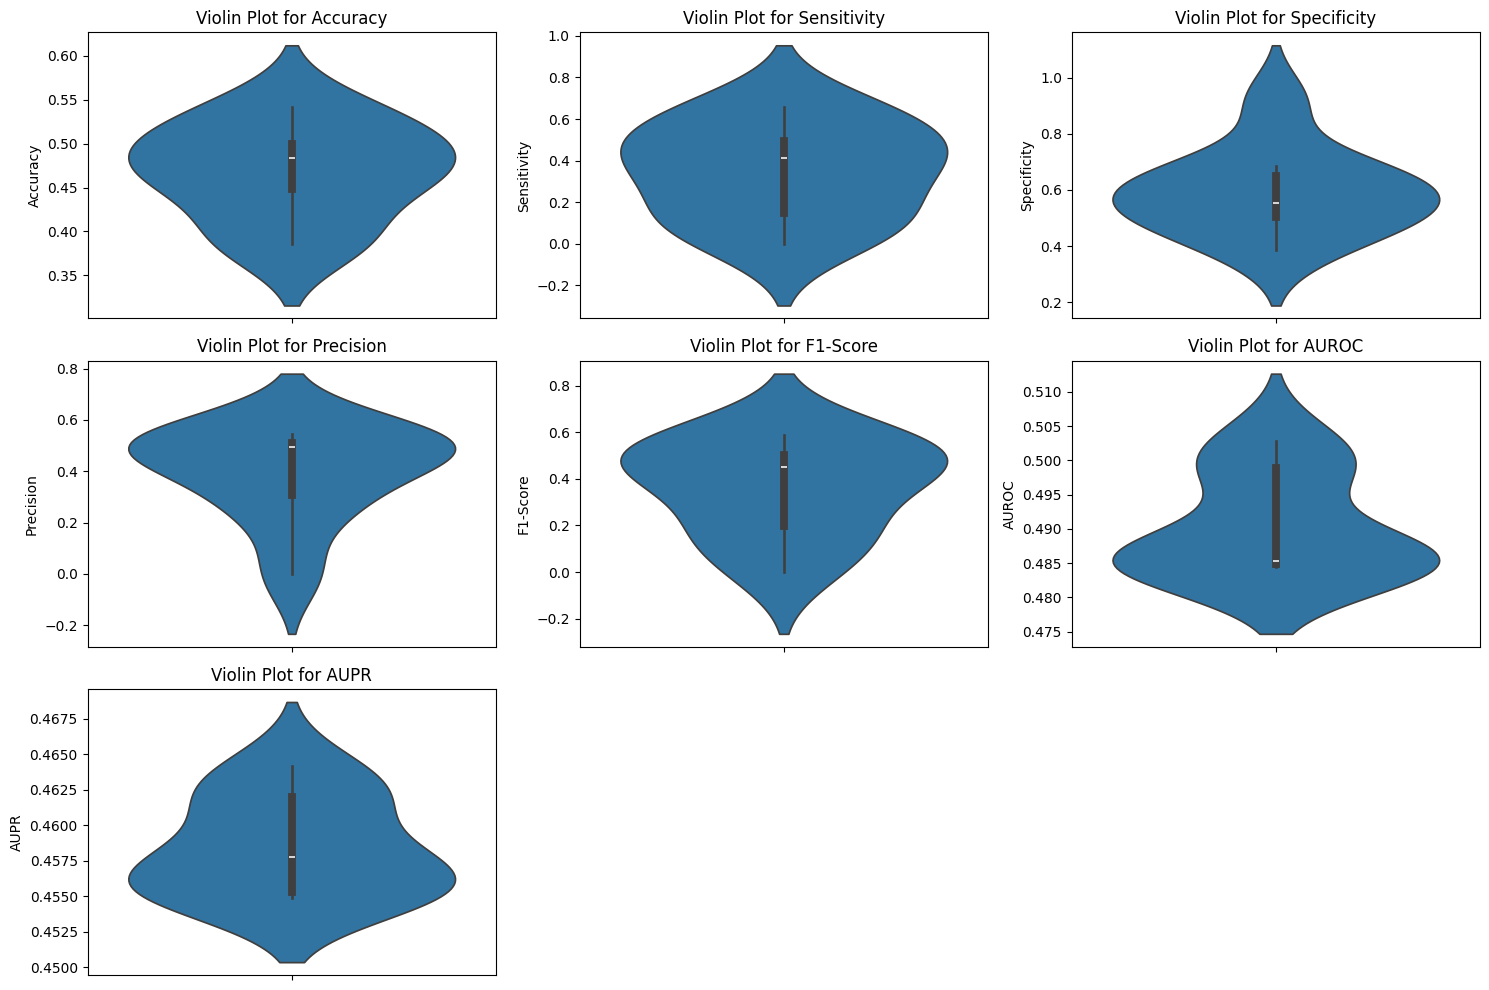

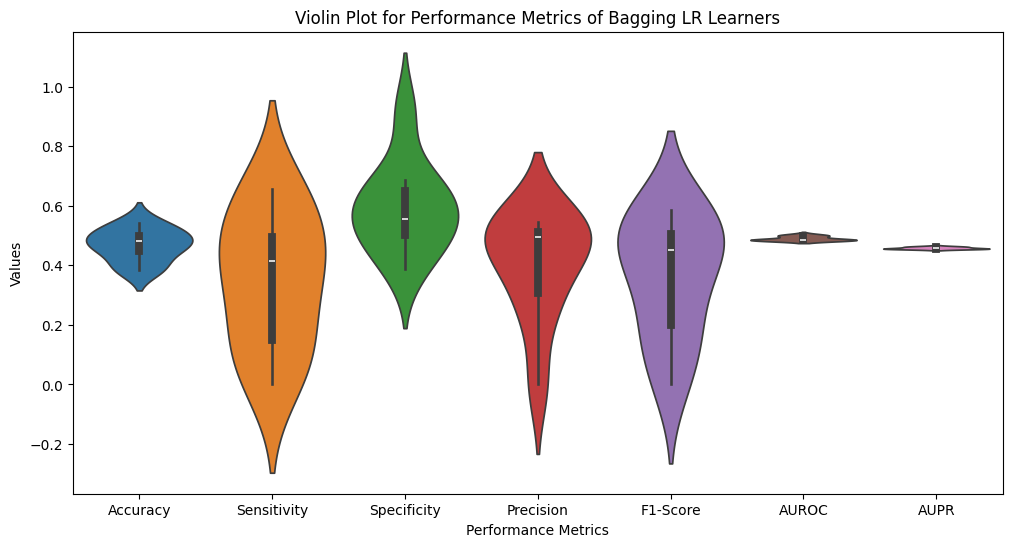

,Accuracy,Sensitivity,Specificity,Precision,F1-Score,AUROC,AUPR
LR,0.468 ± 0.051,0.347 ± 0.217,0.595 ± 0.144,0.397 ± 0.171,0.362 ± 0.194,0.490 ± 0.007,0.458 ± 0.003
Voting ensemble,0.469697,0.296053,0.651724,0.471204,0.363636,0.483859,0.453448
Stacking ensemble,0.737374,0.753289,0.72069,0.73871,0.745928,0.785923,0.760954


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

ensemble = Ensemble(base_learner_num=9)
ensemble.train_base_learner(X_train,y_train)
ensemble.train_meta_classifier(X_val,y_val)

metrics = ["Accuracy","Sensitivity","Specificity","Precision","F1-Score","AUROC","AUPR"]
metric_values = []

for model in ensemble.base_learner:
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_with_probability(X_test)
    metric_values.append(performance_metrics(y_test,y_pred,y_pred_prob))

data = pd.DataFrame(metric_values,columns=metrics)

metric_values = np.array(metric_values).T

table = pd.DataFrame(columns=metrics)

temp = []
for i in range(len(metrics)):
    temp.append(f"{np.mean(metric_values[i]):.3f} ± {np.std(metric_values[i]):.3f}")
table.loc["LR"] = temp

y_pred = ensemble.majority_voting_prediction(X_test)
y_pred_prob = ensemble.majority_voting_prediction_with_probability(X_test)
table.loc["Voting ensemble"] = performance_metrics(y_test,y_pred,y_pred_prob)

y_pred = ensemble.predict(X_test)
y_pred_prob = ensemble.predict_with_probability(X_test)
table.loc["Stacking ensemble"] = performance_metrics(y_test,y_pred,y_pred_prob)

plt.figure(figsize=(15, 10))

for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(data=data, y=column)
    plt.title(f'Violin Plot for {column}')
    plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))

sns.violinplot(data=data)

plt.title('Violin Plot for Performance Metrics of Bagging LR Learners')
plt.xlabel('Performance Metrics')
plt.ylabel('Values')

plt.show()

table
